# Clustering Yelp Restaurants

**To be completed INDIVIDUALLY and due on Febrary 17 at 7pm.**

In this assignment, we will be working with the [Yelp dataset](https://www.yelp.com/dataset/challenge). Download the data from Round 11. You can find the format of the dataset [here](https://www.yelp.com/dataset/documentation/json).

a) From the Business Objects, let's try to find culinary districts in **Las Vegas**. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" to cluster for similarity. You are going to use the following popular categories: 'Mexican', 'Fast Food', 'Pizza', 'American (Traditional)', 'Sandwitches', 'Breakfast & Brunch', 'Chinese', 'Italian'.

Note that the spatial coordinates and restaurant categories have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling. For this purpose, you need to scale the latitude and longitude at a range from [1,5].

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. **(3 pts)**

In [1]:
import json
import pandas as pd
from sklearn import preprocessing
import numpy as np

np.set_printoptions(threshold=np.nan)

business = []
popcats = ['Mexican', 'Fast Food', 'Pizza', 'American (Traditional)', 'Sandwiches', 'Breakfast & Brunch', 'Chinese', 'Italian']
with open('business.json') as f:
    for line in f:
        tmp = json.loads(line)
        if tmp['city']=='Las Vegas': #filtering city
            if 'Restaurants' in tmp['categories']: #filtering restaurant
                tmpcat = []
                
                for item in tmp['categories']: #adds relevant categories
                    for item2 in popcats:
                        if (item == item2):
                            tmpcat.append(item)
                if tmpcat:
                    business.append([tmp['latitude'], tmp['longitude'], tmpcat]) #appends to list
labels = ['lat', 'long', 'cats']
df = pd.DataFrame(business, columns = labels) #move to df

print(df)

min_max_scaler = preprocessing.MinMaxScaler()

lat_minmax = min_max_scaler.fit_transform(df.loc[:, 'lat'].values.reshape(-1,1))
long_minmax = min_max_scaler.fit_transform(df.loc[:, 'long'].values.reshape(-1,1)) #scales values to 0 to 1

latoneto5list = []
longoneto5list = []
for index in range(len(lat_minmax)):
    temp1 = (((lat_minmax[index] - lat_minmax.min()) * (10 - 5)) / (lat_minmax.max() - lat_minmax.min())) + 5 #scales values to 5 to 10
    temp2 = (((long_minmax[index] - long_minmax.min()) * (10 - 5)) / (long_minmax.max() - long_minmax.min())) + 5
    latoneto5list.append(temp1)
    longoneto5list.append(temp2)
    
latoneto5 = np.array(latoneto5list)
longoneto5 = np.array(longoneto5list)

df.loc[:,'lat'] = latoneto5 #changed df
df.loc[:,'long'] = longoneto5
print(df)

            lat        long                                               cats
0     36.064652 -115.118954                            [Fast Food, Sandwiches]
1     36.111057 -115.241688                                          [Italian]
2     36.130013 -115.109310                                        [Fast Food]
3     36.112895 -115.062353                            [Sandwiches, Fast Food]
4     36.034244 -115.171409                           [American (Traditional)]
5     36.010086 -115.118656                                   [Italian, Pizza]
6     36.098632 -115.136079                                          [Mexican]
7     36.271838 -115.263279                           [American (Traditional)]
8     36.140925 -115.142887       [American (Traditional), Breakfast & Brunch]
9     36.238059 -115.210341                                            [Pizza]
10    36.159483 -115.287451                                          [Mexican]
11    36.122084 -115.168032                         

In [2]:
#vectorize
list1 = df.loc[:,'cats']
print (list1.values)
final = []


#makes one vector of all cats, removing special characters and spacing
#this is done for the vectorization further, not removing this would lead to imbalance, with some
#categories being more heavily weighted
for item in list1:
    stringbuilder = ''
    if (len(item) > 1):
        for item2 in item:
            
            temp = item2

            temp = temp.replace(" ", "")
            temp = temp.replace("(" , "")
            temp = temp.replace(")" , "")
            temp = temp.replace("&", "")

            stringbuilder += temp + " "
    else:
        temp = str(item[0])

        temp = temp.replace(" ", "")
        temp = temp.replace("(" , "")
        temp = temp.replace(")" , "")
        temp = temp.replace("&", "")
 
        stringbuilder=temp
    final.append(stringbuilder)

print(final)

#vectorization
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
mtx = vectorizer.fit_transform(final)
print(vectorizer.get_feature_names())
mtx = (mtx.toarray())

finalM = mtx.tolist()
counter = 0

#list of final feature vector, with vectors + long + lat
print(finalM)
for item in finalM:
    item.append(float(latoneto5[counter]))
    item.append(float(longoneto5[counter]))
    counter+=1

print(finalM)

[['Fast Food', 'Sandwiches'] ['Italian'] ['Fast Food']
 ['Sandwiches', 'Fast Food'] ['American (Traditional)']
 ['Italian', 'Pizza'] ['Mexican'] ['American (Traditional)']
 ['American (Traditional)', 'Breakfast & Brunch'] ['Pizza'] ['Mexican']
 ['Fast Food', 'Chinese'] ['Mexican'] ['Sandwiches', 'Breakfast & Brunch']
 ['Fast Food'] ['Fast Food'] ['Pizza'] ['American (Traditional)']
 ['Sandwiches', 'Pizza'] ['Sandwiches'] ['Sandwiches', 'Fast Food']
 ['Fast Food', 'American (Traditional)'] ['Mexican']
 ['Fast Food', 'Mexican'] ['Breakfast & Brunch'] ['Mexican']
 ['Sandwiches', 'Fast Food'] ['American (Traditional)'] ['Pizza']
 ['Chinese', 'Fast Food'] ['Pizza'] ['Mexican']
 ['Fast Food', 'American (Traditional)'] ['Mexican'] ['Pizza', 'Italian']
 ['Breakfast & Brunch'] ['Fast Food'] ['Mexican'] ['Fast Food'] ['Chinese']
 ['Mexican'] ['Mexican'] ['Pizza'] ['Mexican'] ['Mexican'] ['Fast Food']
 ['Mexican'] ['Pizza'] ['American (Traditional)'] ['Pizza'] ['Fast Food']
 ['Pizza'] ['Fast Food

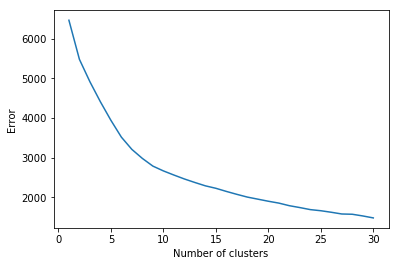

In [3]:
#Kmeans
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

#using elbow method to get appropriate K
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

evaluate_clusters(finalM, 30) #maybe 9 clusters

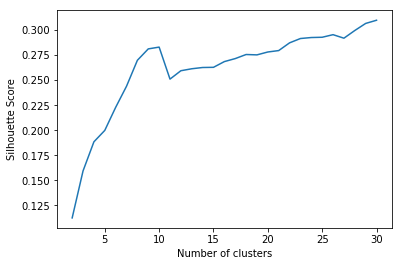

In [4]:
#Hierarchal

import scipy.cluster
import scipy.cluster.hierarchy as hierarchy
import scipy.spatial.distance
import sklearn.metrics as metrics
%matplotlib inline

Z_20ng = hierarchy.linkage(finalM, method='ward', metric='euclidean')

#checking silouette score in hierarchal rating for good K, seems to be 9
max_clusters = 30
s = np.zeros(max_clusters+1)
for k in range(2,max_clusters+1):
    clusters = hierarchy.fcluster(Z_20ng, k, criterion='maxclust')
    s[k] = metrics.silhouette_score(finalM,clusters,metric='euclidean')
plt.plot(range(2,len(s)),s[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

In [5]:
#final GMM 
from sklearn import mixture

finalM2 = finalM

gmm = mixture.GaussianMixture(n_components=9, covariance_type='full')

gmm.fit(finalM2)

y_pred = gmm.predict(finalM2)

In [6]:
#final K means
kmeans = KMeans(init='k-means++', n_clusters=9, n_init=10)
kmeans.fit_predict(finalM)
labels = kmeans.labels_

#final hierarchal
Z_20ng = hierarchy.linkage(finalM, method='ward', metric='euclidean')
clusters = hierarchy.fcluster(Z_20ng, 9, criterion='maxclust')

b) Explain your data representation and how you determined certain parameters (for example, the number of clusters for each method). **(1 pt)**

The final data was a feature vector of the 8 categories and longitude and latitude. I used this data for the Kmeans++, hierarchal, and GMM clustering. The K chosen was 9 because it represented the highest value on the silouette score and seemed to be the elbow of the K means clustering.

c) Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Label each cluster with a category. In a markdown, explain how labels are assigned. **(2 pts)**

Note that some categories are inherently more common (e.g. "pizza"). When labeling your clusters, you want to avoid the scenario where all clusters are labeled as "pizza" simply because of the uniformly large number of these restaurants across all clusters. In other words, we don’t want to point out that pizza restaurants are pretty much evenly distributed in high quantities everywhere, but rather discover when they, or another type of restaurant, appear in notably high quantities.

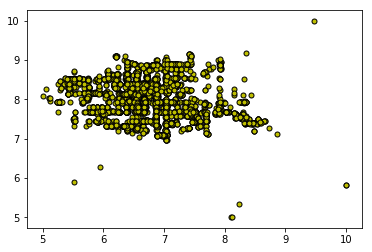

In [7]:
plt.scatter(latoneto5, longoneto5, marker='o', c='y',
            s=25, edgecolor='k')

[[  4.15254237e-01   1.00000000e+00   2.82485876e-03   5.64971751e-03
    2.25988701e-02   3.67231638e-02   8.47457627e-03   1.75141243e-01
    6.60343978e+00   7.98758281e+00]
 [  1.00000000e+00   6.80011603e-16   1.97628458e-03   8.89328063e-02
    1.97628458e-02   1.97628458e-03   2.37154150e-02   7.31225296e-02
    6.50712001e+00   8.07207069e+00]
 [  2.04918033e-01   1.06557377e-01   6.28415301e-02   3.71584699e-01
    7.10382514e-02   1.85792350e-01   1.93989071e-01   2.02185792e-01
    8.03923760e+00   7.66348331e+00]
 [  1.31332083e-02   3.93996248e-02   1.87617261e-03   1.87617261e-03
    9.38086304e-03   1.00000000e+00   3.75234522e-03   3.75234522e-03
    6.73490143e+00   8.19580873e+00]
 [  5.71428571e-02   8.57142857e-03   3.33066907e-16   1.14285714e-02
    8.74300632e-16   2.85714286e-03   1.00000000e+00   1.60000000e-01
    6.60674940e+00   8.08509682e+00]
 [  7.44416873e-03   2.48138958e-03   1.00000000e+00   1.11662531e-01
    4.96277916e-03   2.48138958e-03  -1.60982

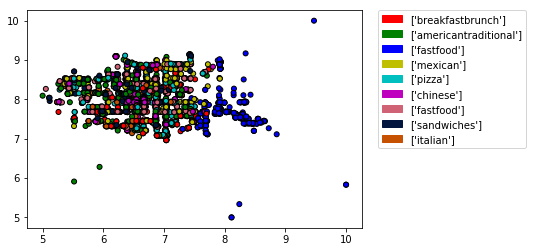

In [8]:
import matplotlib.patches as mpatches

finalN = np.asarray(finalM)

#print(finalN)
#print(finalN[:,10])
#print(finalN[:,11])

CATS_list = vectorizer.get_feature_names()

LABEL_COLOR_MAP = {0: 'r', 1:'g', 2:'b', 3:'y', 4: 'c', 5:'m', 6: 'xkcd:rose', 7: 'xkcd:navy', 8:'xkcd:dark orange', 9:'xkcd:gunmetal'}
label_color = [LABEL_COLOR_MAP[l] for l in labels]
#dictionary of colors to keep things consistent

centroids = kmeans.cluster_centers_
tags = []
print (centroids)
for item in centroids:
    tempR = []
    greatest = 0
    for index in range(len(CATS_list)):
        if item[index] > greatest:
            greatest = item[index]
            tempR.append(CATS_list[index])
    tags.append([(tempR[-1])])
#getting largest 1 tag in a cluster

print(tags)

red_patch = mpatches.Patch(color='r', label=tags[0])
red_patch1 = mpatches.Patch(color='g', label=tags[1])
red_patch2 = mpatches.Patch(color='b', label=tags[2])
red_patch3 = mpatches.Patch(color='y', label=tags[3])
red_patch4 = mpatches.Patch(color='c', label=tags[4])
red_patch5 = mpatches.Patch(color='m', label=tags[5])
red_patch6 = mpatches.Patch(color='xkcd:rose', label=tags[6])
red_patch7 = mpatches.Patch(color='xkcd:navy', label=tags[7])
red_patch8 = mpatches.Patch(color='xkcd:dark orange', label=tags[8])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, handles=[red_patch, red_patch1, red_patch2, red_patch3, red_patch4, red_patch5, red_patch6, red_patch7, red_patch8])
plt.scatter(finalN[:,8], finalN[:,9], marker='o', c=label_color,s=25, edgecolor='k')

[4 7 3 4 2 8 0 2 1 5 0 3 0 1 3 3 8 2 5 4 4 2 0 0 1 0 4 2 8 3 8 0 2 0 8 1 3
 0 3 6 0 0 8 0 0 3 0 8 2 8 3 8 3 0 6 2 4 1 2 2 3 6 0 4 0 5 3 0 1 6 8 0 1 2
 6 0 4 0 5 5 8 0 2 3 2 8 8 6 0 2 4 6 3 1 1 2 7 2 5 8 8 1 1 0 3 8 8 7 2 0 3
 3 1 5 2 5 0 2 4 4 2 8 5 3 4 2 1 4 7 2 3 4 0 0 1 3 7 8 8 8 6 2 7 0 3 4 1 0
 0 2 2 1 6 8 1 2 0 2 0 4 6 6 4 4 0 7 6 7 2 3 5 0 2 0 1 2 1 6 2 6 5 7 0 3 8
 0 4 4 3 8 4 0 3 1 0 4 4 2 0 3 4 6 4 2 1 2 3 0 6 0 8 0 7 2 3 8 0 2 6 0 4 4
 6 3 6 2 1 6 0 0 8 1 3 4 7 1 5 4 2 8 6 0 0 5 2 1 0 0 2 8 3 0 1 4 4 6 5 3 1
 4 8 2 8 3 8 0 4 6 8 1 4 4 1 2 5 7 8 6 4 8 2 2 0 0 5 3 1 5 0 3 8 6 0 7 2 2
 7 6 6 6 4 2 4 8 7 2 2 0 2 2 0 7 4 0 0 8 8 2 3 8 2 8 2 7 8 3 7 5 0 5 4 0 0
 3 4 4 7 6 2 0 5 4 3 1 1 0 5 2 0 5 8 6 2 0 3 3 2 3 3 5 2 6 7 2 6 3 2 3 0 8
 3 3 8 0 3 0 1 0 6 0 6 0 8 2 1 3 4 0 0 7 3 8 8 5 3 8 6 0 3 7 2 0 5 3 2 2 0
 6 2 6 4 0 2 1 0 1 8 4 3 8 6 4 7 2 0 5 7 5 0 0 4 3 3 4 3 0 8 5 0 8 2 4 2 7
 6 3 0 6 0 5 4 3 7 0 4 2 6 0 6 5 2 2 3 6 3 2 4 0 2 3 7 0 2 8 1 2 2 6 6 0 6
 3 1 0 6 3 2 4 3 2 6 7 5 

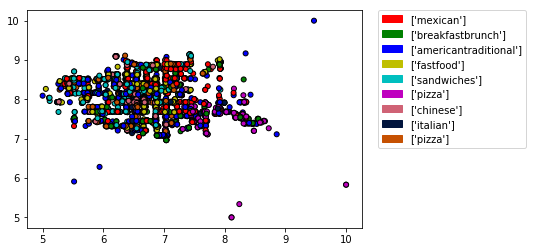

In [9]:
#print(clusters)

hClusterCount = np.zeros(9)

clusters2 = np.zeros(len(clusters))
clusters2 = clusters-1
#adjusting the clusters of hierarchy (went from 1-9 rather than 0-8)

print(clusters2)
for index in range(len(clusters2)):
    hClusterCount[clusters2[index]] = hClusterCount[clusters2[index]]+1
    
print(hClusterCount)
#getting size of clusters

Hcenters = []

#making the centroids of the clusters
for index in range(len(hClusterCount)):
    counter = 0
    tempcluster = np.zeros((int(hClusterCount[index]), 10))
    for index2 in range(len(clusters2)):
        if (clusters2[index2])==index:
            tempcluster[counter] = finalN[index2]
            counter+=1
    tempcentroid = np.array([np.average(tempcluster[:,0]), np.average(tempcluster[:,1]), np.average(tempcluster[:,2]), 
                            np.average(tempcluster[:,3]), np.average(tempcluster[:,4]), np.average(tempcluster[:,5]), 
                             np.average(tempcluster[:,6]), np.average(tempcluster[:,7]), np.average(tempcluster[:,8]),
                             np.average(tempcluster[:,9])
                            ])
    Hcenters.append(tempcentroid.tolist())

print(Hcenters)

#getting highest tag
tags = []
for item in Hcenters:
    tempR = []
    greatest = 0
    for index in range(len(CATS_list)):
        if item[index] > greatest:
            greatest = item[index]
            tempR.append(CATS_list[index])
    tags.append([(tempR[-1])])

print(tags)

label_color = [LABEL_COLOR_MAP[l] for l in clusters2]

red_patch = mpatches.Patch(color='r', label=tags[0])
red_patch1 = mpatches.Patch(color='g', label=tags[1])
red_patch2 = mpatches.Patch(color='b', label=tags[2])
red_patch3 = mpatches.Patch(color='y', label=tags[3])
red_patch4 = mpatches.Patch(color='c', label=tags[4])
red_patch5 = mpatches.Patch(color='m', label=tags[5])
red_patch6 = mpatches.Patch(color='xkcd:rose', label=tags[6])
red_patch7 = mpatches.Patch(color='xkcd:navy', label=tags[7])
red_patch8 = mpatches.Patch(color='xkcd:dark orange', label=tags[8])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, handles=[red_patch, red_patch1, red_patch2, red_patch3, red_patch4, red_patch5, red_patch6, red_patch7, red_patch8])

plt.scatter(finalN[:,8], finalN[:,9], marker='o', c=label_color,s=25, edgecolor='k')

[['pizza'], ['mexican'], ['americantraditional'], ['fastfood'], ['americantraditional'], ['breakfastbrunch'], ['chinese'], ['sandwiches'], ['mexican']]


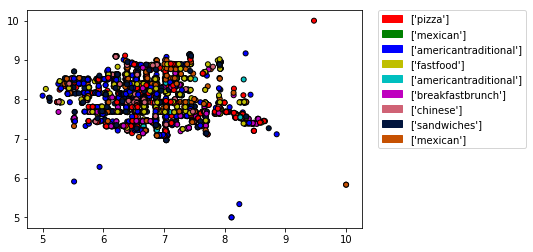

In [10]:
label_color = [LABEL_COLOR_MAP[l] for l in y_pred]

#getting highest tag
tags = []
for item in gmm.means_:
    tempR = []
    greatest = 0
    for index in range(len(CATS_list)):
        if item[index] > greatest:
            greatest = item[index]
            tempR.append(CATS_list[index])
    tags.append([(tempR[-1])])

print(tags)

red_patch = mpatches.Patch(color='r', label=tags[0])
red_patch1 = mpatches.Patch(color='g', label=tags[1])
red_patch2 = mpatches.Patch(color='b', label=tags[2])
red_patch3 = mpatches.Patch(color='y', label=tags[3])
red_patch4 = mpatches.Patch(color='c', label=tags[4])
red_patch5 = mpatches.Patch(color='m', label=tags[5])
red_patch6 = mpatches.Patch(color='xkcd:rose', label=tags[6])
red_patch7 = mpatches.Patch(color='xkcd:navy', label=tags[7])
red_patch8 = mpatches.Patch(color='xkcd:dark orange', label=tags[8])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, handles=[red_patch, red_patch1, red_patch2, red_patch3, red_patch4, red_patch5, red_patch6, red_patch7, red_patch8])

plt.scatter(finalN[:,8], finalN[:,9], marker='o', c=label_color,s=25, edgecolor='k')

Clusters were labeled based on the highest average feature of the feature vector excluding latitude and longitude. 

d) Now let's detect outliers. These are the points that are the farthest from the centroids of their clusters. In order to find the outliers, you need to find the distances of all cluster points from the centroid and select the ones whose distance is above the 85th percentile. **(3 pts)**

In [11]:
import sklearn.metrics as metrics
from scipy.spatial import distance

def get_outliers(centers, clusterindex):
    counter = 0
    
    #make a list that stores the errors of a cluster
    errorlist = []
    for k in range(len(centers)):
        errorlist.append([])

    absoluteError = []
    #list of overall error in order of points

    for index in range(len(clusterindex)):
        change = distance.euclidean(finalN[index], centers[clusterindex[index]])
        errorlist[clusterindex[index]].append((change))
        absoluteError.append(change)

    percentileRange = []
    for index in errorlist:
        percentileRange.append(np.percentile(index,95))
        #getting percentile error per cluster

    print(percentileRange)
    
    outliers = []
    for k in range(len(centers)):
        outliers.append([])

    #getting outliers percluster
    for index in range(len(percentileRange)):
        for index2 in ((errorlist[index])):
            if (percentileRange[index] < index2):
                outliers[index].append((index2))

    #print(outliers)
    outliercount = 0

    #loop that prints out the whole feature vector of outliers, including lat and long
    for index in range(len(outliers)):
        print("for cluster " + str(index) + ": ")
        for point in outliers[index]:
            for index2 in range(len(absoluteError)):
                if (point == absoluteError[index2]) & (clusterindex[index2] == index):
                    print(finalN[index2])
                    outliercount+=1

    print(outliercount)
    
get_outliers(centroids, labels)

[1.4589461894434235, 1.298092040428962, 1.578457692262323, 1.2828787600552447, 1.3426191147998285, 1.2575006648114646, 1.2855597138803447, 1.2630836786697879, 1.3544386759164251]
for cluster 0: 
[ 0.          1.          0.          0.          0.          0.          0.
  1.          5.41967941  8.13646761]
[ 1.          1.          0.          0.          0.          0.          1.
  1.          5.58035897  8.51485722]
[ 1.          1.          0.          0.          0.          1.          0.
  0.          5.39465202  8.53004179]
[ 1.          1.          0.          0.          0.          1.          0.
  1.          5.96630681  7.69165206]
[ 1.          1.          0.          0.          0.          0.          0.
  1.          5.26143153  7.68084669]
[ 0.          1.          0.          0.          0.          0.          0.
  0.          5.1068728   8.03965533]
[ 1.          1.          0.          0.          0.          1.          0.
  1.          7.51198273  8.51105256]


[ 0.          0.          0.          0.          0.          1.          0.
  0.          5.42128299  8.13712748]
[ 0.          0.          0.          0.          0.          1.          0.
  0.          5.51731768  7.3214448 ]
[ 0.          0.          0.          1.          0.          1.          0.
  0.          7.72322908  8.89319891]
[ 0.          0.          0.          0.          0.          1.          0.
  0.          5.46227217  8.51325652]
[ 0.          1.          0.          0.          0.          1.          0.
  0.          7.67378793  7.91976834]
[ 1.          0.          0.          0.          1.          1.          0.
  0.          6.74564775  8.7425911 ]
[ 0.          0.          0.          0.          0.          1.          0.
  0.          7.91919117  8.86301749]
[ 0.          0.          0.          0.          0.          1.          0.
  0.          5.43076974  8.51121212]
[ 1.          0.          0.          0.          1.          1.          0.
  0

[ 0.          0.          0.          1.          0.          0.          0.
  0.          7.67946757  8.69983993]
[ 0.          0.          0.          1.          0.          1.          0.
  0.          7.43796925  9.10996523]
[ 0.          0.          0.          1.          0.          1.          0.
  0.          7.03097037  7.08228825]
[ 0.          0.          0.          1.          0.          0.          0.
  0.          7.43793592  9.13061416]
[ 0.          0.          0.          1.          0.          1.          0.
  0.          5.26598925  7.93780932]
[ 0.          0.          0.          1.          0.          1.          0.
  0.          5.28450996  7.94667862]
[ 0.          0.          0.          1.          0.          1.          0.
  0.          5.52048894  8.51546135]
[ 0.          0.          0.          1.          0.          1.          0.
  0.          7.01028182  7.08293761]
[ 0.          0.          0.          1.          0.          1.          0.
  0

In [12]:
#hierarchal

#centroids already made
get_outliers(Hcenters, clusters2)

[1.4529016587583983, 1.789343161732265, 1.6663324621129147, 1.4329004036068456, 1.4479739593358503, 1.441948767216763, 1.1814352100997865, 1.4510970756659525, 1.346642249202225]
for cluster 0: 
[ 0.          0.          0.          1.          0.          1.          0.
  0.          8.27958321  7.62896299]
[ 0.          0.          0.          0.          0.          1.          0.
  0.          5.39166604  8.52890875]
[ 0.          0.          0.          1.          0.          1.          0.
  0.          8.46138748  7.39125936]
[ 0.          0.          0.          0.          0.          1.          0.
  0.          8.5452312   7.50477938]
[ 0.          0.          0.          0.          0.          1.          0.
  0.          8.30172099  7.92934085]
[ 0.          0.          0.          0.          0.          1.          0.
  0.          8.37068392  7.39250679]
[ 0.          0.          0.          1.          0.          1.          0.
  0.          7.92845535  8.78537433]
[

[ 1.          1.          0.          0.          0.          0.          0.
  0.          8.38736747  7.39318354]
[ 1.          0.          0.          0.          0.          0.          0.
  0.          5.51861033  5.91330541]
[ 1.          0.          0.          0.          0.          0.          1.
  1.          6.95100769  7.0891124 ]
[ 1.          1.          0.          0.          0.          0.          0.
  0.          8.52450984  7.37884007]
[ 1.          1.          0.          1.          0.          0.          0.
  0.          7.91736567  8.53101317]
[ 1.          0.          0.          1.          0.          0.          0.
  0.          8.24351414  7.92701062]
[ 1.          1.          0.          0.          0.          0.          0.
  0.          8.26161667  7.55460148]
[ 1.          0.          0.          0.          0.          0.          0.
  0.          5.93811669  6.28526371]
[ 1.          0.          0.          0.          0.          0.          0.
  0

  0.          7.01965161  7.23253223]
[ 1.          0.          0.          0.          0.          0.          0.
  0.          8.11360776  5.        ]
[  0.           0.           0.           0.           0.           1.           0.
   0.          10.           5.83269778]
[  0.           0.           0.           0.           0.           1.           0.
   0.          10.           5.83269778]
for cluster 6: 
[ 0.          0.          1.          0.          0.          0.          0.
  0.          5.49279877  8.52375391]
[ 0.          0.          1.          0.          0.          0.          0.
  0.          7.41731744  9.14140915]
[ 0.          0.          1.          0.          0.          0.          0.
  0.          5.42007985  8.38875624]
[ 0.          0.          1.          0.          0.          0.          0.
  0.          5.4949152   8.52341119]
[ 0.          0.          1.          0.          0.          0.          0.
  0.          5.40914986  8.41539786]
[ 0.  

In [13]:
get_outliers(gmm.means_, y_pred)

[1.6604766202447692, 1.7446706666028309, 1.6286854425931749, 1.6143777547317977, 1.9558086901940659, 1.6761310698162315, 1.3728709944076538, 1.6482358462399413, 1.4472730178864956]
for cluster 0: 
[ 0.          0.          0.          0.          0.          0.          1.
  0.          8.25794855  7.521572  ]
[ 0.          0.          0.          0.          1.          0.          0.
  0.          8.45662754  7.39198436]
[ 0.          0.          0.          0.          0.          0.          1.
  0.          8.36320695  7.53730105]
[ 0.          0.          0.          0.          0.          0.          1.
  0.          8.35396091  7.93775612]
[ 0.          0.          0.          0.          0.          0.          1.
  0.          8.56900963  7.43787345]
[ 0.          0.          0.          0.          1.          0.          0.
  0.          8.27686815  7.53097852]
[ 0.          0.          0.          0.          1.          0.          0.
  0.          5.24193518  7.93000625

  0.          8.26471627  7.92799542]
[ 0.          0.          0.          1.          0.          1.          0.
  0.          5.28276655  8.4643797 ]
[ 0.          0.          0.          1.          0.          1.          0.
  0.          8.48176095  7.39178051]
[ 0.          0.          0.          1.          0.          1.          0.
  0.          5.2976242   8.28022789]
[ 0.          0.          0.          1.          0.          1.          0.
  0.          5.28760531  7.92526562]
[ 0.          0.          0.          1.          0.          0.          0.
  0.          8.45865101  7.38492018]
[ 1.          0.          0.          1.          0.          0.          0.
  0.          8.19175066  7.59676534]
[ 1.          0.          0.          1.          0.          0.          0.
  0.          5.29565088  7.92643822]
[ 0.          0.          0.          1.          0.          1.          0.
  0.          8.26592647  7.92823359]
[ 1.          0.          0.          1.  

  1.          8.35415933  7.56393769]
for cluster 8: 
[ 0.          0.          0.          0.          0.          1.          0.
  0.          8.19006188  7.5896751 ]
[ 0.          1.          0.          0.          0.          1.          0.
  0.          5.60546961  8.40719031]
[ 0.          1.          0.          0.          0.          1.          0.
  0.          5.79678476  7.68139125]
[ 0.          0.          0.          0.          0.          1.          0.
  0.          5.39166604  8.52890875]
[ 0.          0.          0.          0.          0.          1.          0.
  0.          8.5452312   7.50477938]
[ 0.          0.          0.          0.          0.          1.          0.
  0.          8.30172099  7.92934085]
[ 0.          0.          0.          0.          0.          1.          0.
  0.          8.37068392  7.39250679]
[ 0.         0.         0.         0.         0.         1.         0.         0.
  8.2593956  7.5227625]
[ 0.          0.          0.       

e) Give an analysis comparing the results you obtained from the 3 techniques. **(1 pts)**

The clusters from the 3 techniques were slightly different from each other. K means produced two fast food clusters, while the other two produced two pizza clusters. GMM also produced two mexican clusters, while skipping a breakfast and brunch cluster all together.  
From these results, because of the large size of the fast food cluster in K means, and the skipping of the breakfast and brunch category in GMM, I would say that the hierarchal clustering came out with the best result.  
When looking at outliers (defined as 95 percentile error), all three clusters came out with similar results, between 194-196 outliers.

----------